| Termo            | Significado                             |
|------------------|-----------------------------------------|
| HeartDisease     | Doença cardíaca                         |
| BMI              | Índice de massa corporal                |
| Smoking          | Fumar (hábito de fumar)                |
| AlcoholDrinking  | Consumo de álcool                       |
| Stroke           | Acidente vascular cerebral (AVC)        |
| PhysicalHealth   | Saúde física                            |
| MentalHealth     | Saúde mental                            |
| DiffWalking      | Dificuldade para caminhar               |
| Sex              | Sexo (masculino ou feminino)            |
| AgeCategory      | Categoria de idade                      |
| Race             | Raça                                    |
| Diabetic         | Diabético                               |
| PhysicalActivity | Atividade física                        |
| GenHealth        | Saúde geral                             |
| SleepTime        | Tempo de sono                           |
| Asthma           | Asma                                    |
| KidneyDisease    | Doença renal                            |
| SkinCancer       | Câncer de pele                          |


In [2]:
from sklearn.exceptions import DataConversionWarning
import warnings
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

In [3]:
warnings.filterwarnings('ignore',category=DataConversionWarning)

In [4]:
data = pd.read_csv(r'datasets/HeartDiseasePredictionClassification/2020/heart_2020_cleaned.csv')

In [5]:
data.head(3)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No


In [6]:
data['HeartDisease'].value_counts()

HeartDisease
No     292422
Yes     27373
Name: count, dtype: int64

> dados esta desbalanceados 

In [7]:
data.shape

(319795, 18)

Verificando se ha valores nulos

In [8]:
data.isna().nunique().reset_index().set_index('index').T

index,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


> Não tem valores nulos   

In [9]:
#Valores binario
unico = data.nunique()
binario  = unico.loc[unico.values==2].index.tolist()

#Valores numericos
numerico = data.select_dtypes(include='float').columns.to_list()

#Valores categoricos ordinais
cat = data.select_dtypes(exclude='float').nunique()
categorico = cat.loc[cat.values>2].index

pegando as colunas binarias

In [10]:
numbers = []
for valores in data['AgeCategory'].unique():
    if '-' in valores:
        valores = int(valores.split('-')[0])
    else:
        valores = int(valores.split('or')[0])
    numbers.append(valores)
numbers = sorted(numbers)
numbers

[18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

> isso sera utizadado para modificar a coluna 

&nbsp;

# Preprocessamento

In [40]:
from sklearn.preprocessing import LabelEncoder , LabelBinarizer, StandardScaler
from sklearn.base          import BaseEstimator, TransformerMixin
from sklearn.pipeline      import Pipeline
from sklearn.metrics       import *

In [12]:
class TransformandoAtributos(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list|str, dtyped=LabelBinarizer()):
        self.columns = columns
        self.dtyped  = dtyped

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        for column in self.columns:
            X[column] = self.dtyped.fit_transform(X[column].values.reshape(-1,1))
        return X   

In [13]:
class TransformandoAtributosIdade(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list|str, numbers:list):
        self.columns = columns
        self.numbers = numbers

    def fit(self,X,y=None):
        return self
    
    def transform(self,X:pd.DataFrame,y=None):
        for e,num_i in enumerate(numbers):
            X.loc[ X[self.columns].str.contains(str(num_i)),self.columns ] = str(e)             
        return X

In [14]:
class Dummies(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list | str) -> None:
        self.columns = columns 

    def fit(self,X,y=None):
        return self
    
    def transform(self, X:pd.DataFrame):
        return pd.get_dummies(X,columns=self.columns,dtype=int)

&nbsp;

In [15]:
pipeline = Pipeline(
    steps=[
        ('binario'      , TransformandoAtributos(binario)),
        ('categorizando', TransformandoAtributosIdade('AgeCategory',numbers)),
        ('Labelencoder' , TransformandoAtributos(categorico,dtyped=LabelEncoder())),
        ('padronizacao' , TransformandoAtributos(numerico  ,dtyped=StandardScaler())),
        ('dummies'      , Dummies(categorico))
    ]
)
data = pipeline.fit_transform(data)

### target features

In [16]:
y = data['HeartDisease'].values
X = data.drop(columns=['HeartDisease']).values

### balanceando dados

In [17]:
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(sampling_strategy={0:27373 ,1:27373},random_state=42)

Xunder, Yunder = under.fit_resample(X ,y)

#### Definindo conjunto de teste e treinamento

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
xtrain, xtest, ytrain, ytest = train_test_split(Xunder, Yunder, test_size=0.25, random_state=42)

In [20]:
xtrain.shape

(41059, 41)

&nbsp;

### Usando rede neural sequincial

In [21]:
import keras

2024-03-17 19:27:47.610150: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 19:27:47.675335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 19:27:47.675401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 19:27:47.677240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 19:27:47.687303: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 19:27:47.688412: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [42]:
def Model():
    initializer = keras.initializers.VarianceScaling(scale=2. , mode='fan_in', distribution='normal', seed=32)
    model = keras.models.Sequential(
        layers=[
            keras.layers.Dense(80, activation=keras.activations.selu, kernel_initializer=initializer),
            keras.layers.Dense(40, activation=keras.activations.selu, kernel_initializer=initializer),
            keras.layers.Dense(20, activation=keras.activations.selu, kernel_initializer=initializer),
            keras.layers.Dense(10, activation=keras.activations.selu, kernel_initializer=initializer),
            keras.layers.Dense(5, activation=keras.activations.selu, kernel_initializer=initializer),
            keras.layers.Dense(1, activation=keras.activations.selu),
        ]
    )
    return model

In [43]:
model = Model()
model.compile(
    optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8,nesterov=True, clipnorm=1.0),
    loss      = keras.losses.binary_crossentropy,
    metrics   = [keras.metrics.binary_accuracy]
)
history = model.fit(xtrain, ytrain, batch_size=42, epochs=20, validation_split=0.1)

Epoch 1/20
880/880 [==============================] - 3s 2ms/step - loss: 3.5864 - binary_accuracy: 0.6872 - val_loss: 2.1082 - val_binary_accuracy: 0.7328
Epoch 2/20
880/880 [==============================] - 2s 2ms/step - loss: 1.2378 - binary_accuracy: 0.7298 - val_loss: 0.7905 - val_binary_accuracy: 0.7562
Epoch 3/20
880/880 [==============================] - 2s 2ms/step - loss: 0.6564 - binary_accuracy: 0.7485 - val_loss: 0.6320 - val_binary_accuracy: 0.7582
Epoch 4/20
880/880 [==============================] - 2s 2ms/step - loss: 0.6150 - binary_accuracy: 0.7534 - val_loss: 0.5852 - val_binary_accuracy: 0.7642
Epoch 5/20
880/880 [==============================] - 2s 2ms/step - loss: 0.5947 - binary_accuracy: 0.7557 - val_loss: 0.5678 - val_binary_accuracy: 0.7655
Epoch 6/20
880/880 [==============================] - 2s 2ms/step - loss: 0.5870 - binary_accuracy: 0.7586 - val_loss: 0.5418 - val_binary_accuracy: 0.7681
Epoch 7/20
880/880 [==============================] - 1s 2ms/ste

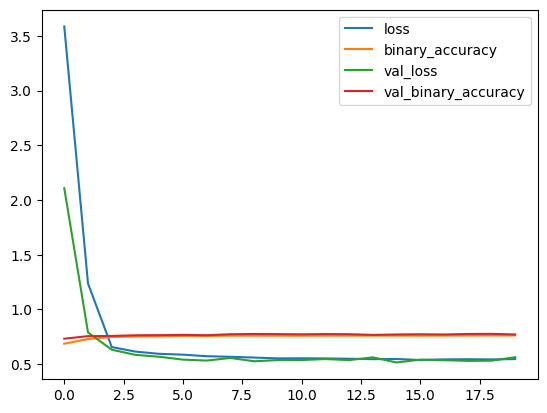

In [49]:
pd.DataFrame(history.history).plot()
plt.show()

In [44]:
pred = model.predict(xtest)>0.5

428/428 [==============================] - 1s 1ms/step


In [46]:
accuracy_score(ytest, pred)

0.7591875502301454

In [50]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.82      0.67      0.73      6825
           1       0.72      0.85      0.78      6862

    accuracy                           0.76     13687
   macro avg       0.77      0.76      0.76     13687
weighted avg       0.77      0.76      0.76     13687



### Usando Sklearn

In [28]:
from sklearn.linear_model    import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [35]:
params = dict(
    loss     = ['hinge','huber'],
    l1_ratio = np.random.uniform(0,1,size=10),
)

grid = GridSearchCV(
    estimator =SGDClassifier(penalty='elasticnet'),
    param_grid=params,
    scoring   ='accuracy'
)
grid.fit(xtrain, ytrain)

GridSearchCV(estimator=SGDClassifier(penalty='elasticnet'),
             param_grid={'l1_ratio': array([0.26655841, 0.58611569, 0.00944342, 0.77409591, 0.13173311,
       0.06555439, 0.23345861, 0.23094171, 0.05132505, 0.58140889]),
                         'loss': ['hinge', 'huber']},
             scoring='accuracy')

In [37]:
grid.best_estimator_
grid.best_score_

0.7640712686099451